 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [3]:
# !pip install torchmetrics

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchmetrics import Accuracy



In [4]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
# I will split the trainset into validation and train
valid_size = 0.2

data_size = len(trainset)
indices = list(range(data_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * data_size))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

Скачаем обучающую и контрольную выборки.

In [6]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
                                          sampler=train_sampler, num_workers=2)

validloader = torch.utils.data.DataLoader(trainset, batch_size=20, 
                                          sampler=valid_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=20,
                                         shuffle=False, num_workers=2)



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [7]:
acc = Accuracy(top_k=1)

In [8]:
classes_map = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle Boot')

print("Train size:", trainloader.dataset.data.shape[0])
print("Test size:", testloader.dataset.data.shape[0])

Train size: 60000
Test size: 10000


[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


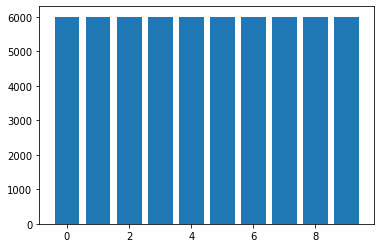

In [9]:
# Train distribution
unique_test, counts_test = np.unique(trainloader.dataset.targets, return_counts=True)
plt.bar(unique_test, counts_test)
print(counts_test)

[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


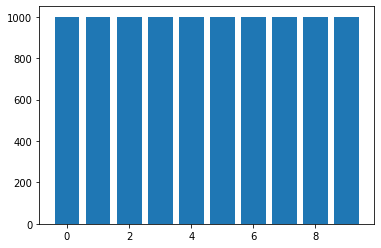

In [10]:
# Test distribution
unique_test, counts_test = np.unique(testloader.dataset.targets, return_counts=True)
plt.bar(unique_test, counts_test)
print(counts_test)

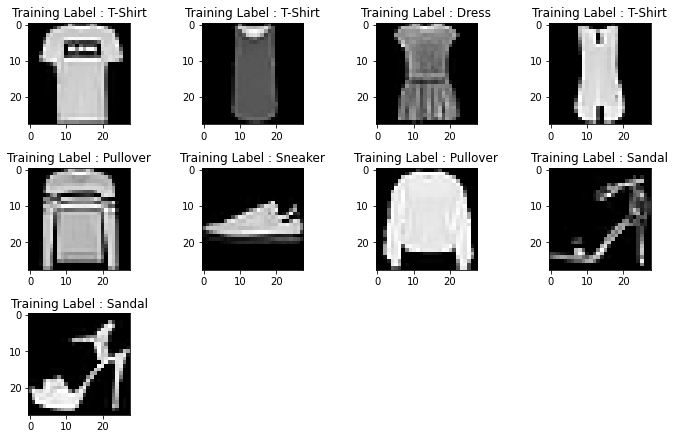

In [11]:
fig = plt.figure(figsize=(10,10));
columns = 4;
rows = 5;
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.imshow(trainloader.dataset.data[i].numpy(), cmap='gray')
    plt.title(f"Training Label : {classes_map[trainloader.dataset.targets[i]]}")
plt.show()

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x
        




In [13]:
MLP_network = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_network.parameters(), lr=0.01)

In [14]:
n_epochs = 35

valid_loss_min = np.Inf 

mlp_train_loss = []
mlp_validation_loss = []

mlp_train_accuracy = []
mlp_validation_accuracy = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train
    acc_train_sum = 0
    acc_valid_sum = 0
    MLP_network.train()
    for data, target in trainloader:
        optimizer.zero_grad()
        output = MLP_network(data)
        acc_train_sum += acc(output, target).item()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    # validate
    MLP_network.eval() 
    for data, target in validloader:
        output = MLP_network(data)
        acc_valid_sum += acc(output, target).item()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.dataset)
    mlp_train_loss.append(train_loss)

    valid_loss = valid_loss/len(validloader.dataset)
    mlp_validation_loss.append(valid_loss)

    acc_train = acc_train_sum / len(trainloader.dataset)
    mlp_train_accuracy.append(acc_train)

    acc_valid = acc_valid_sum / len(validloader.dataset)
    mlp_validation_accuracy.append(acc_valid)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(MLP_network.state_dict(), 'MLP.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.771768 	Validation Loss: 0.117556
Epoch: 2 	Training Loss: 0.450882 	Validation Loss: 0.098644
Epoch: 3 	Training Loss: 0.390754 	Validation Loss: 0.087966
Epoch: 4 	Training Loss: 0.359488 	Validation Loss: 0.085363
Epoch: 5 	Training Loss: 0.338841 	Validation Loss: 0.078298
Epoch: 6 	Training Loss: 0.322380 	Validation Loss: 0.076273
Epoch: 7 	Training Loss: 0.308616 	Validation Loss: 0.073158
Epoch: 8 	Training Loss: 0.296434 	Validation Loss: 0.071360
Epoch: 9 	Training Loss: 0.287566 	Validation Loss: 0.073679
Epoch: 10 	Training Loss: 0.279300 	Validation Loss: 0.069643
Epoch: 11 	Training Loss: 0.271684 	Validation Loss: 0.067550
Epoch: 12 	Training Loss: 0.264253 	Validation Loss: 0.068843
Epoch: 13 	Training Loss: 0.258125 	Validation Loss: 0.064913
Epoch: 14 	Training Loss: 0.252365 	Validation Loss: 0.063657
Epoch: 15 	Training Loss: 0.245246 	Validation Loss: 0.066122
Epoch: 16 	Training Loss: 0.241765 	Validation Loss: 0.063916
Epoch: 17 	Traini

In [15]:
MLP_network.load_state_dict(torch.load('MLP.pt'))

<All keys matched successfully>

In [16]:

test_loss = 0.0
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

MLP_network.eval()

for data, target in testloader:
    output = MLP_network(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.311276

Test Accuracy of     0: 87% (873/1000)
Test Accuracy of     1: 97% (973/1000)
Test Accuracy of     2: 80% (809/1000)
Test Accuracy of     3: 90% (909/1000)
Test Accuracy of     4: 85% (856/1000)
Test Accuracy of     5: 95% (955/1000)
Test Accuracy of     6: 66% (661/1000)
Test Accuracy of     7: 95% (952/1000)
Test Accuracy of     8: 96% (969/1000)
Test Accuracy of     9: 96% (963/1000)

Test Accuracy (Overall): 89% (8920/10000)


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        x = x.view(100, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          sampler=train_sampler, num_workers=2)

validloader = torch.utils.data.DataLoader(trainset, batch_size=100, 
                                          sampler=valid_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

In [27]:
CNN_network = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_network.parameters(), lr=0.001)

In [28]:
n_epochs = 10

valid_loss_min = np.Inf 

cnn_train_loss = []
cnn_validation_loss = []


cnn_train_accuracy = []
cnn_validation_accuracy = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    acc_train_sum = 0
    acc_valid_sum = 0
    # train
    CNN_network.train()
    for data, target in trainloader:
        optimizer.zero_grad()
        output = CNN_network(data)
        acc_train_sum += acc(output, target).item()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    # validate
    CNN_network.eval() 
    for data, target in validloader:
        output = CNN_network(data)
        acc_valid_sum += acc(output, target).item()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.dataset)
    cnn_train_loss.append(train_loss)

    valid_loss = valid_loss/len(validloader.dataset)
    cnn_validation_loss.append(valid_loss)

    acc_train = acc_train_sum/len(trainloader.dataset)
    cnn_train_accuracy.append(acc_train)

    acc_valid = acc_valid_sum/len(validloader.dataset)
    cnn_validation_accuracy.append(acc_valid)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(CNN_network.state_dict(), 'CNN.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.360243 	Validation Loss: 0.069640
Epoch: 2 	Training Loss: 0.247649 	Validation Loss: 0.057827
Epoch: 3 	Training Loss: 0.210844 	Validation Loss: 0.054196
Epoch: 4 	Training Loss: 0.193902 	Validation Loss: 0.061180
Epoch: 5 	Training Loss: 0.177360 	Validation Loss: 0.057802
Epoch: 6 	Training Loss: 0.162949 	Validation Loss: 0.052798
Epoch: 7 	Training Loss: 0.154369 	Validation Loss: 0.046755
Epoch: 8 	Training Loss: 0.140860 	Validation Loss: 0.051639
Epoch: 9 	Training Loss: 0.134878 	Validation Loss: 0.050285
Epoch: 10 	Training Loss: 0.122701 	Validation Loss: 0.053806


In [29]:
CNN_network.load_state_dict(torch.load('CNN.pt'))

<All keys matched successfully>

In [30]:
test_loss = 0.0
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

CNN_network.eval()

for data, target in testloader:
    output = CNN_network(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(100):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.251151

Test Accuracy of     0: 82% (825/1000)
Test Accuracy of     1: 99% (990/1000)
Test Accuracy of     2: 86% (860/1000)
Test Accuracy of     3: 90% (909/1000)
Test Accuracy of     4: 88% (882/1000)
Test Accuracy of     5: 99% (995/1000)
Test Accuracy of     6: 78% (786/1000)
Test Accuracy of     7: 92% (922/1000)
Test Accuracy of     8: 99% (990/1000)
Test Accuracy of     9: 97% (978/1000)

Test Accuracy (Overall): 91% (9137/10000)


## Plots

### MLP accuracy and loss

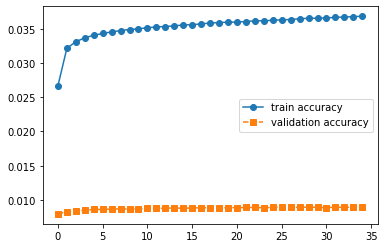

In [23]:
plt.plot(mlp_train_accuracy, '-o', label = "train accuracy")
plt.plot(mlp_validation_accuracy,'--s', label = "validation accuracy")
plt.legend()
plt.show()

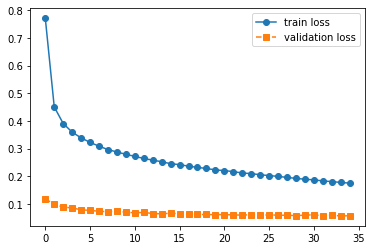

In [24]:
plt.plot(mlp_train_loss, '-o', label = "train loss")
plt.plot(mlp_validation_loss,'--s', label = "validation loss")
plt.legend()
plt.show()

### CNN accuracy and loss

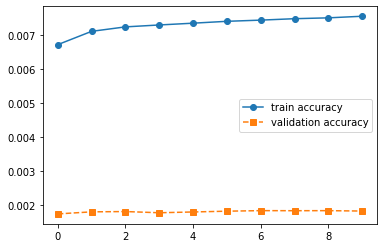

In [31]:
plt.plot(cnn_train_accuracy, '-o', label = "train accuracy")
plt.plot(cnn_validation_accuracy,'--s', label = "validation accuracy")
plt.legend()
plt.show()

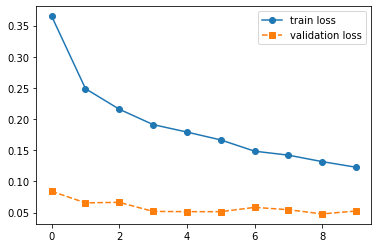

In [26]:
plt.plot(cnn_train_loss, '-o', label = "train loss")
plt.plot(cnn_validation_loss,'--s', label = "validation loss")
plt.legend()
plt.show()